In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from tqdm import tqdm
import glob
import cv2

import warnings
warnings.filterwarnings('ignore')

In [13]:
# download dataset
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2020-05-14 12:55:22--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz.1’

lfw.tgz.1            15%[==>                 ]  27.43M   128KB/s    eta 16m 42s^C


In [14]:
# extract dataset
! tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Aiken/Clay_Aiken_000

In [0]:
#capture paths to images
face_images = glob.glob('lfw/**/*.jpg')

In [16]:
# Load the Images
raw_data = []

for fl in tqdm(face_images):
  current_img = image.load_img(fl, target_size=(80, 80, 3))
  current_img = image.img_to_array(current_img)
  current_img = current_img / 255.
  raw_data.append(current_img)

100%|██████████| 13233/13233 [00:18<00:00, 718.77it/s]


In [0]:
# Split the training data
raw_data = np.array(raw_data)
trainX, testX = train_test_split(raw_data, test_size=0.15)

In [0]:
def to_lowres(image: np.ndarray, scaling_factor=0.5):
  """
  Converts an image to low resolution one using the scaling factor
  Scaling Factor --> [0.1 --- 0.9] i.e: [10% --- 90%]
  Process:
    First Resize the input image to smaller dimensions using the scaling factor
    and then resize it back to the original dimensions, thus effectively making
    it of lower resolution
  """
  scale_height = int(image.shape[0] * scaling_factor)
  scale_width = int(image.shape[1] * scaling_factor)

  orig_height = image.shape[0]
  orig_width = image.shape[1]

  smaller_img = cv2.resize(image, (scale_width, scale_height))
  low_res_img = cv2.resize(smaller_img, (orig_width, orig_height), interpolation=cv2.INTER_AREA)

  return low_res_img

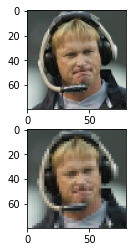

In [36]:
# Test the function
test = trainX[92]
fig, axs = plt.subplots(2)
axs[0].imshow(test)
axs[1].imshow(to_lowres(test))

In [0]:
# Lets make a dataset of lowres images for both train and test
train_lrs = []
test_lrs = []

for i in range(trainX.shape[0]):
  temp = to_lowres(trainX[i,:,:,:])
  train_lrs.append(temp)

for i in range(testX.shape[0]):
  temp = to_lowres(testX[i,:,:,:])
  test_lrs.append(temp)

train_lrs = np.array(train_lrs)
test_lrs = np.array(test_lrs)

In [0]:
# Build the model
input_ = Input(shape=(80, 80, 3))
e1 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(input_)
e2 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(e1)
e2 = MaxPool2D()(e2)
e3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(e2)

d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(e3)
d1 = UpSampling2D()(d1)
d2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d1)
d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)

output = Conv2D(3, (3, 3), padding='same')(d3)

ae = Model(input_, output)
ae.compile(optimizer='adam', loss='mse')

In [41]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 80, 80, 64)        0     

In [42]:
early_stopper = EarlyStopping(min_delta=0.0003, patience=4, verbose=1, mode='auto')

ae.fit(x=train_lrs, y=trainX, epochs=50, batch_size=256, shuffle=True, validation_data=(test_lrs, testX), callbacks=[early_stopper])

Epoch 1/50
44/44 [==============================] - 179s 4s/step - loss: 0.0896 - val_loss: 0.0158
Epoch 2/50
44/44 [==============================] - 157s 4s/step - loss: 0.0107 - val_loss: 0.0067
Epoch 3/50
44/44 [==============================] - 157s 4s/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/50
44/44 [==============================] - 157s 4s/step - loss: 0.0036 - val_loss: 0.0031
Epoch 5/50
44/44 [==============================] - 157s 4s/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/50
44/44 [==============================] - 157s 4s/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/50
44/44 [==============================] - 158s 4s/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/50
44/44 [==============================] - 158s 4s/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/50
44/44 [==============================] - 158s 4s/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/50
44/44 [==============================] - 158s 4s/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/

KeyboardInterrupt: ignored

In [0]:
# Let's do inference on our testing data
preds = ae.predict(test_lrs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


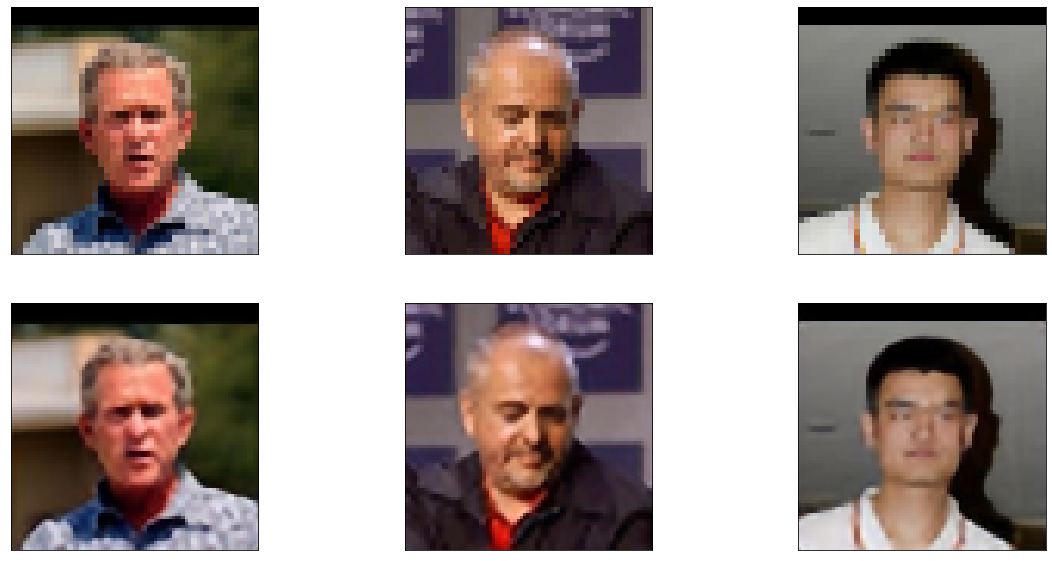

In [48]:
# Compare the Images
num = 3
plt.figure(figsize=(20,10))
for i in range(num):
  ax = plt.subplot(2, num, i+1)
  plt.imshow(test_lrs[i+5])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, num, i+1+num)
  plt.imshow(preds[i+5])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # The Top ones are Low resolution images and the bottom ones are the
  # predicted high resolution images